<a href="https://colab.research.google.com/github/SevilayMuni/Ecommerce-insights-platform/blob/main/e_commerce_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation and Personalized Marketing Dashboard
The goal of this project is to create a Customer Segmentation and Personalized Marketing Dashboard using the Brazilian E-Commerce Public Dataset by Olist.   
  
*The dashboard will help the marketing team understand customer behavior, segment customers based on their purchasing patterns, and design personalized marketing campaigns.*

Brazilian E-Commerce Public Dataset by Olist: Contains 100k orders from 2016 to 2018 with multiple dimensions such as order status, price, payment, customer location, product attributes, and customer reviews.

## Coding Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Data Prep

In [2]:
# Load datasets
customers = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/customer-segmentation/commerce-data/olist_customers_dataset.csv")
geolocation = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/customer-segmentation/commerce-data/olist_geolocation_dataset.csv")
order_items = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/customer-segmentation/commerce-data/olist_order_items_dataset.csv")
orders = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/customer-segmentation/commerce-data/olist_orders_dataset.csv")
products = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/customer-segmentation/commerce-data/olist_products_dataset.csv")
payments = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/customer-segmentation/commerce-data/olist_order_payments_dataset.csv")
reviews = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/customer-segmentation/commerce-data/olist_order_reviews_dataset.csv")
sellers = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/customer-segmentation/commerce-data/olist_sellers_dataset.csv")
translation = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/customer-segmentation/commerce-data/product_category_name_translation.csv")

# Check datasets
customers.shape, geolocation.shape, order_items.shape, orders.shape, products.shape, payments.shape, reviews.shape, sellers.shape

((99441, 5),
 (1000163, 5),
 (112650, 7),
 (99441, 8),
 (32951, 9),
 (103886, 5),
 (99224, 7),
 (3095, 4))

### Merge Datasets

In [3]:
# Merge datasets on 'order id'
orders_items = orders.merge(order_items, on = "order_id", how = "left")
orders_payments = orders_items.merge(payments, on = "order_id", how = "left")
orders_payments_reviews = orders_payments.merge(reviews, on = "order_id", how = "left")
orders_df = orders_payments_reviews.drop(columns = ["review_comment_title",
                                                    "review_comment_message",
                                                    "review_creation_date",
                                                    "review_answer_timestamp"])
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       119143 non-null  object 
 1   customer_id                    119143 non-null  object 
 2   order_status                   119143 non-null  object 
 3   order_purchase_timestamp       119143 non-null  object 
 4   order_approved_at              118966 non-null  object 
 5   order_delivered_carrier_date   117057 non-null  object 
 6   order_delivered_customer_date  115722 non-null  object 
 7   order_estimated_delivery_date  119143 non-null  object 
 8   order_item_id                  118310 non-null  float64
 9   product_id                     118310 non-null  object 
 10  seller_id                      118310 non-null  object 
 11  shipping_limit_date            118310 non-null  object 
 12  price                         

In [4]:
orders_customers = orders_df.merge(customers, on = "customer_id", how = "left")
orders_customers_sellers = orders_customers.merge(sellers, on = "seller_id", how = "left")
orders_customers_sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       119143 non-null  object 
 1   customer_id                    119143 non-null  object 
 2   order_status                   119143 non-null  object 
 3   order_purchase_timestamp       119143 non-null  object 
 4   order_approved_at              118966 non-null  object 
 5   order_delivered_carrier_date   117057 non-null  object 
 6   order_delivered_customer_date  115722 non-null  object 
 7   order_estimated_delivery_date  119143 non-null  object 
 8   order_item_id                  118310 non-null  float64
 9   product_id                     118310 non-null  object 
 10  seller_id                      118310 non-null  object 
 11  shipping_limit_date            118310 non-null  object 
 12  price                         

In [5]:
# Replace Portuguese Categories with English Translations
# Merge product data with category translation
products2 = products.merge(translation, left_on = "product_category_name",
                           right_on = "product_category_name", how="left")

# Drop the original Portuguese category column and rename the English column
products = products2.drop(columns=["product_category_name"]).rename(columns={"product_category_name_english":
                                                                             "product_category"})

# Display updated product table
products.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares


In [6]:
# Merge datasets on 'product_id'
all_df = orders_customers_sellers.merge(products, on = "product_id", how = "left")
df = all_df.drop(columns = ["product_name_lenght", "product_description_lenght",
                            "product_length_cm", "product_height_cm", "product_width_cm"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       119143 non-null  object 
 1   customer_id                    119143 non-null  object 
 2   order_status                   119143 non-null  object 
 3   order_purchase_timestamp       119143 non-null  object 
 4   order_approved_at              118966 non-null  object 
 5   order_delivered_carrier_date   117057 non-null  object 
 6   order_delivered_customer_date  115722 non-null  object 
 7   order_estimated_delivery_date  119143 non-null  object 
 8   order_item_id                  118310 non-null  float64
 9   product_id                     118310 non-null  object 
 10  seller_id                      118310 non-null  object 
 11  shipping_limit_date            118310 non-null  object 
 12  price                         

## Data Analysis

### 1.1. Customer Segmentation

In [7]:
# Aggregate customer purchase behavior
customer_summary = df.groupby("customer_unique_id").agg({"order_id": ["nunique", "count"],
                                                         "payment_value": "sum",
                                                         "order_purchase_timestamp": ["min", "max"],
                                                         }).reset_index()
# Rename colums
customer_summary.columns = ["customer_id", "total_order", "frequency",
                            "total_spending", "first_order", "last_order"]
customer_summary.head()

,customer_id,total_order,frequency,total_spending,first_order,last_order
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,141.90,2018-05-10 10:56:27,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,27.19,2018-05-07 11:11:27,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,1,1,86.22,2017-03-10 21:05:03,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,43.62,2017-10-12 20:29:41,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,1,1,196.89,2017-11-14 19:45:42,2017-11-14 19:45:42


In [8]:
# Convert to datetime
customer_summary["first_order"] = pd.to_datetime(customer_summary["first_order"])
customer_summary["last_order"] = pd.to_datetime(customer_summary["last_order"])
# Compute days since last purchase
latest_date = customer_summary["last_order"].max()
customer_summary["recency"] = latest_date - customer_summary["last_order"]
customer_summary["recency"] = customer_summary["recency"].dt.days
customer_summary["avg_spending"] = customer_summary["total_spending"]/customer_summary["total_order"]
customer_summary.head()

,customer_id,total_order,frequency,total_spending,first_order,last_order,recency,avg_spending
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,141.90,2018-05-10 10:56:27,2018-05-10 10:56:27,160,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,27.19,2018-05-07 11:11:27,2018-05-07 11:11:27,163,27.19
2,0000f46a3911fa3c0805444483337064,1,1,86.22,2017-03-10 21:05:03,2017-03-10 21:05:03,585,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,43.62,2017-10-12 20:29:41,2017-10-12 20:29:41,369,43.62
4,0004aac84e0df4da2b147fca70cf8255,1,1,196.89,2017-11-14 19:45:42,2017-11-14 19:45:42,336,196.89


#### RFM (Recency, Frequency, Monetary) Analysis
RFM Scoring: Quantifies customer behavior into three dimensions (Recency, Frequency, Monetary).

Segmentation: Grouping customers into actionable segments based on their RFM scores.

In [9]:
# RFM Scoring with dynamic label assignment
customer_summary["r_score"], recency_bins = pd.qcut(customer_summary["recency"],
                                                    q = 4, retbins = True,
                                                    duplicates = "drop")
customer_summary["f_score"], frequency_bins = pd.qcut(customer_summary["frequency"],
                                                      q = 4, retbins = True,
                                                      duplicates = "drop")
customer_summary["m_score"], total_spending_bins = pd.qcut(customer_summary["total_spending"],
                                                           q = 4, retbins = True,
                                                           duplicates = "drop")

# Dynamically assign labels based on the number of bins
customer_summary["r_score"] = pd.qcut(customer_summary["recency"], q = 4,
                                      labels = range(len(recency_bins)-1, 0, -1),
                                      duplicates = "drop")
customer_summary["f_score"] = pd.qcut(customer_summary["frequency"], q = 4,
                                      labels = range(1, len(frequency_bins)),
                                      duplicates = "drop")
customer_summary["m_score"] = pd.qcut(customer_summary["total_spending"], q = 4,
                                      labels = range(1, len(total_spending_bins)),
                                      duplicates = "drop")

# Combine scores to create RFM segments
customer_summary["rfm_score"] = customer_summary["r_score"].astype(str) + customer_summary["f_score"].astype(str) + customer_summary["m_score"].astype(str)

# Update segment_map to reflect the new RFM score patterns
segment_map = {
    r'111|112|113|114|121|131|141|151': 'Lost Customers',  # Low scores in all dimensions
    r'211|212|213|214|221|231|232|223': 'Hibernating Customers',  # Low recency, moderate frequency/spending
    r'311|312|313|314|321|322|331|332': 'At Risk Customers',  # Moderate recency, low frequency/spending
    r'411|412|413|414|421|422|431|432': 'Promising Customers',  # High recency, low frequency/spending
    r'433|434|443|444': 'Loyal Customers',  # High frequency and spending
    r'233|234|243|244': 'Potential Loyalists'  # Moderate recency, high frequency/spending
}

# Segment customers based on RFM scores
customer_summary["segment"] = customer_summary["rfm_score"].replace(segment_map,
                                                                    regex = True)
customer_summary.head()

,customer_id,total_order,frequency,total_spending,first_order,last_order,recency,avg_spending,r_score,f_score,m_score,rfm_score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,141.90,2018-05-10 10:56:27,2018-05-10 10:56:27,160,141.90,4,1,3,413,Promising Customers
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,27.19,2018-05-07 11:11:27,2018-05-07 11:11:27,163,27.19,4,1,1,411,Promising Customers
2,0000f46a3911fa3c0805444483337064,1,1,86.22,2017-03-10 21:05:03,2017-03-10 21:05:03,585,86.22,1,1,2,112,Lost Customers
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,43.62,2017-10-12 20:29:41,2017-10-12 20:29:41,369,43.62,2,1,1,211,Hibernating Customers
4,0004aac84e0df4da2b147fca70cf8255,1,1,196.89,2017-11-14 19:45:42,2017-11-14 19:45:42,336,196.89,2,1,3,213,Hibernating Customers


**Remarks:**

Lost Customers: Target with re-engagement campaigns.   
Potential Loyalists: Encourage with loyalty programs.   
Loyal Customers: Reward and retain.   
Champions: Upsell and leverage for referrals.

In [10]:
segment_analysis = customer_summary.groupby("segment").agg({"total_spending": "mean",
                                                            "total_order": "mean",
                                                            "frequency": "mean",
                                                            "recency": "mean"}).reset_index()
segment_analysis.columns = ["segment", "avg_spending", "avg_order", "avg_frequency", "avg_recency"]
print(segment_analysis)

                 segment  avg_spending  avg_order  avg_frequency  avg_recency
0      At Risk Customers    212.429973   1.037483       1.239890   215.905293
1  Hibernating Customers    216.896507   1.032534       1.239914   327.245398
2         Lost Customers    208.292817   1.027845       1.245011   502.471696
3    Promising Customers    218.979119   1.041348       1.234541   106.138838


#### Segmentation by K-Means

In [11]:
# Select features for clustering
features = customer_summary[["recency", "frequency", "total_spending"]]

# Standardize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
customer_summary["segment_kmeans"] = kmeans.fit_predict(scaled_features)

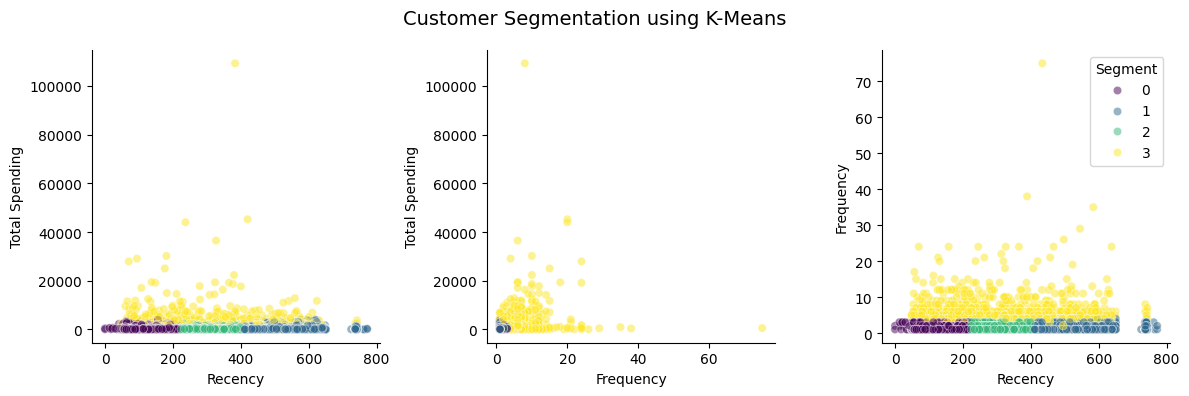

In [12]:
# Visualize the K-Means Segmentation
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.scatterplot(x = features["recency"], y = features["total_spending"],
                hue = customer_summary["segment_kmeans"], palette = 'viridis',
                alpha = 0.5, ax = axes[0], legend  = False)

axes[0].set_xlabel("Recency")
axes[0].set_ylabel("Total Spending")

sns.scatterplot(x = features["frequency"], y = features["total_spending"],
                hue = customer_summary["segment_kmeans"], palette = 'viridis',
                alpha = 0.5, ax = axes[1], legend  = False)

axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Total Spending")

sns.scatterplot(x = features["recency"], y = features["frequency"],
                hue = customer_summary["segment_kmeans"], palette = 'viridis',
                alpha = 0.5, ax = axes[2])

axes[2].set_xlabel("Recency")
axes[2].set_ylabel("Frequency")
axes[2].legend(title = "Segment")

fig.suptitle("Customer Segmentation using K-Means", fontsize=14)
plt.tight_layout()
sns.despine()
plt.show()

#### Demographic Segmentation

In [13]:
# Aggregate customers by state and city
state_segments = df.groupby("customer_state").size().reset_index(name = "order_count")
city_segments = df.groupby("customer_city").size().reset_index(name = "order_count")

# Analyze purchasing patterns by region
orders_by_state = df.groupby("customer_state")["order_id"].count().reset_index(name="order_count").sort_values(by="order_count", ascending=False)
orders_by_city = df.groupby("customer_city")["order_id"].count().reset_index(name="order_count").sort_values(by="order_count", ascending=False)

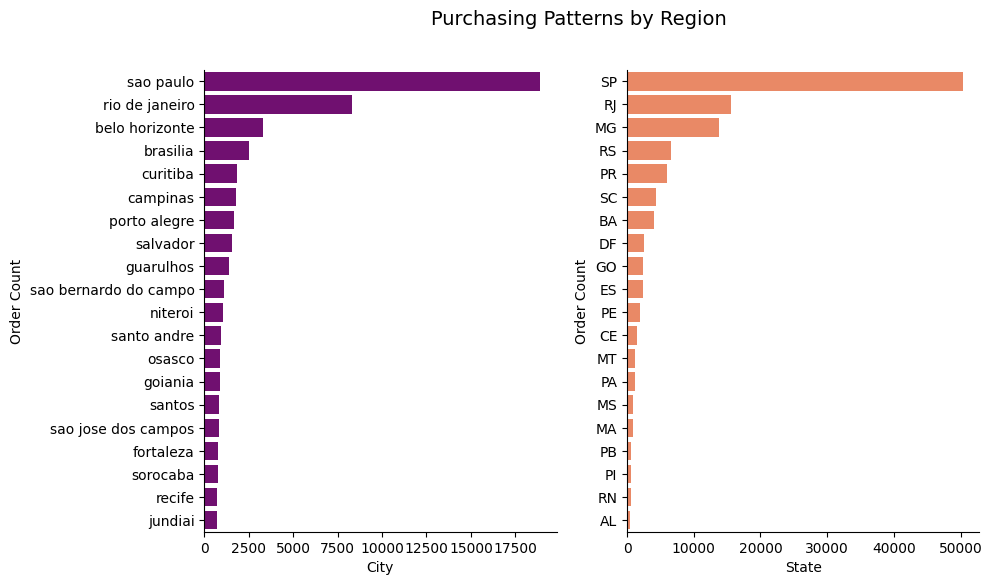

In [14]:
# Visualize the distribution
fig, axes = plt.subplots(1, 2, figsize = (10, 6))
plt.suptitle("Purchasing Patterns by Region", fontsize=14)

sns.barplot(orient = "y",  x = "order_count", y = "customer_city",
            data = orders_by_city[0:20], color = "purple", ax = axes[0])
axes[0].set_xlabel("City")
axes[0].set_ylabel("Order Count")

sns.barplot(orient = "y", x = "order_count", y = "customer_state",
            data = orders_by_state[0:20], color = "coral", ax = axes[1])
axes[1].set_xlabel("State")
axes[1].set_ylabel("Order Count")

sns.despine()
plt.show()

#### Behavioral Segmentation

In [15]:
# Analyze product categories
category_segments = df.groupby("product_category")["order_id"].count().reset_index(name = "purchase_count").sort_values(by = "purchase_count", ascending = False)

# Analyze order frequency
order_frequency = df.groupby("product_category")["review_score"].mean().reset_index(name = "avg_review").sort_values(by = "avg_review", ascending = False)
order_frequency["avg_review"] = round(order_frequency["avg_review"], 2)

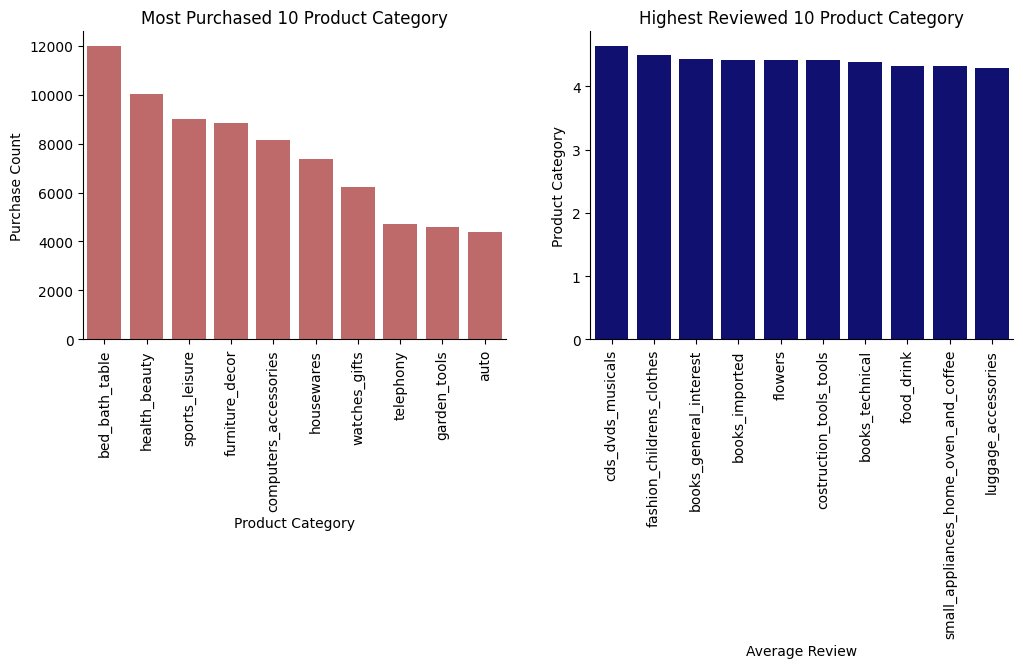

In [16]:
# Plot the analysis
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.barplot(x = "product_category", y = "purchase_count",
            data = category_segments[0:10], color = "indianred", ax = axes[0])
axes[0].set_xlabel("Product Category")
axes[0].set_ylabel("Purchase Count")
axes[0].set_title("Most Purchased 10 Product Category")

# Set the tick labels
ticks = axes[0].get_xticks()
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(category_segments["product_category"][0:10], rotation = 90)

sns.barplot(x = "product_category", y = "avg_review",
            data = order_frequency[0:10], color = "navy", ax = axes[1])
axes[1].set_xlabel("Average Review")
axes[1].set_ylabel("Product Category")
axes[1].set_title("Highest Reviewed 10 Product Category")

# Set the tick labels
ticks = axes[1].get_xticks()
axes[1].set_xticks(ticks)
axes[1].set_xticklabels(order_frequency["product_category"][0:10], rotation = 90)

sns.despine()
plt.show()

### 1.2 Personalized Marketing Insights

#### CLV Calculation
CLV represents the total revenue a business can expect from a customer over the entire duration of their relationship.

In [17]:
# Calculate average order value
avg_order_value = df["payment_value"].mean()

# Calculate purchase frequency
purchase_frequency = df["customer_unique_id"].nunique() / df["order_id"].nunique()

# Calculate customer lifespan
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
customer_lifespan = df.groupby("customer_unique_id")["order_purchase_timestamp"].agg(["min", "max"])
customer_lifespan["lifespan"] = (customer_lifespan["max"] - customer_lifespan["min"]).dt.days
avg_lifespan = customer_lifespan["lifespan"].mean()

# Calculate CLV
clv = avg_order_value * purchase_frequency * avg_lifespan
print(f"Customer Lifetime Value (CLV): {clv}")

Customer Lifetime Value (CLV): 452.6174365539061


**Remarks:**  
The business can expect to earn 452.62 dollars from each customer over their lifetime.  

**Business Implications:**  
*Marketing Budget:* If the cost of acquiring a customer (CAC) is less than $452.62, the business is profitable on a per-customer basis.  
*Customer Retention:* Increasing customer retention can significantly boost CLV, as customers stay longer and make more purchases.  
*Upselling/Cross-Selling:* Encouraging customers to purchase higher-value products or more frequently to increase CLV.

**Strategic Decisions:**  
--> Use CLV to prioritize high-value customers for personalized marketing or loyalty programs.  
--> Allocate resources to retain customers with high CLV and improve the experience for those with low CLV.

In [18]:
# Calculate CLV for each customer
# Calculate average order value per customer
avg_order_value_per_customer = df.groupby("customer_unique_id")["payment_value"].mean()

# Calculate purchase frequency per customer
purchase_frequency_per_customer = df.groupby("customer_unique_id")["order_id"].nunique()

# Calculate customer lifespan
customer_lifespan = df.groupby("customer_unique_id")["order_purchase_timestamp"].agg(["min", "max"])
customer_lifespan["lifespan"] = (customer_lifespan["max"] - customer_lifespan["min"]).dt.days

# Calculate CLV for each customer
customer_clv = (avg_order_value_per_customer * purchase_frequency_per_customer
                * customer_lifespan["lifespan"])

# Sort customers by CLV and select the top 50
top_50_customers = customer_clv.sort_values(ascending = False).head(50)
top_50_clv_customers = df["customer_unique_id"].isin(top_50_customers.index)

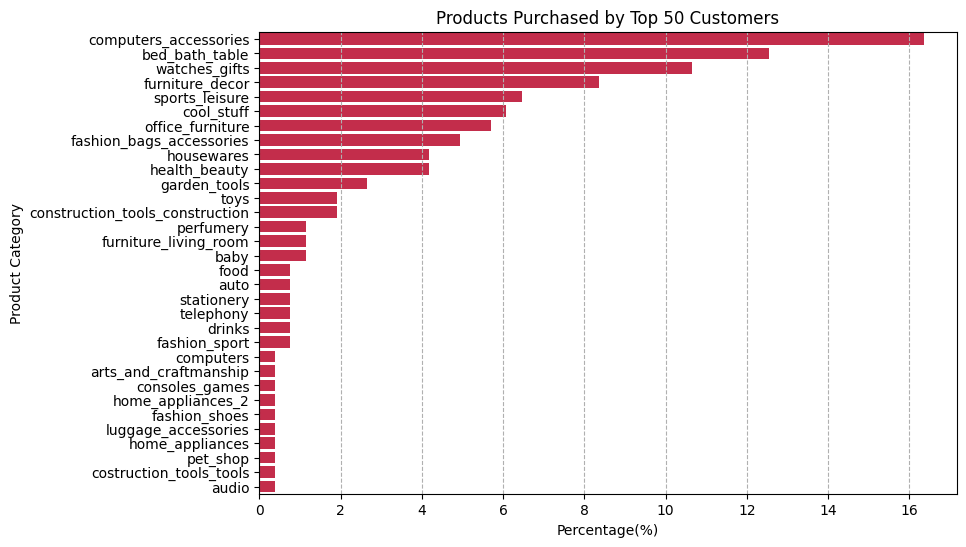

In [19]:
# Plot prudct categories purchased by top 50 customers
df_top_clv = df[df["customer_unique_id"].isin(top_50_customers.index)]
category_count = df_top_clv["product_category"].value_counts(normalize = True)
category_order = category_count.index

plt.figure(figsize = (9, 6))
sns.countplot(orient = "y", y = "product_category", data = df_top_clv,
              color = 'crimson', stat = "percent", order = category_order)
plt.xlabel("Percentage(%)")
plt.ylabel("Product Category")
plt.grid(axis = 'x', linestyle = '--')
plt.title("Products Purchased by Top 50 Customers")
plt.show()

In [20]:
# CLV by quarters
# Group by quarter and calculate CLV components
clv_by_quarter = []
df["year"] = df["order_purchase_timestamp"].dt.year
df["quarter"] = df["order_purchase_timestamp"].dt.quarter
# Combine year and quarter into a single column
df["year_quarter"] = df["year"].astype(str) + "Q" + df["quarter"].astype(str)

for quarter, group in df.groupby("year_quarter"):
    # Calculate average order value for the quarter
    avg_order_value = group["payment_value"].mean()

    # Calculate purchase frequency for the quarter
    purchase_frequency = group["customer_unique_id"].nunique() / group["order_id"].nunique()

    # Calculate customer lifespan for the quarter
    customer_lifespan = group.groupby("customer_unique_id")["order_purchase_timestamp"].agg(["min", "max"])
    customer_lifespan["lifespan"] = (customer_lifespan["max"] - customer_lifespan["min"]).dt.days
    avg_lifespan = customer_lifespan["lifespan"].mean()

    # Calculate CLV for the quarter
    clv = avg_order_value * purchase_frequency * avg_lifespan

    # Get the number of active customers in the quarter
    active_customers = group["customer_unique_id"].nunique()

    # Append the results
    clv_by_quarter.append({"quarter": quarter, "clv": clv,
                           "active_customers": active_customers})

# Convert the results to a DataFrame
clv_by_quarter_df = pd.DataFrame(clv_by_quarter)

# Calculate weighted CLV
clv_by_quarter_df["weighted_clv"] = (clv_by_quarter_df["clv"]
                                     * clv_by_quarter_df["active_customers"]) / clv_by_quarter_df["active_customers"].sum()

clv_by_quarter_df

,quarter,clv,active_customers,weighted_clv
0,2016Q3,0.000000,4,0.000000
1,2016Q4,0.000000,322,0.000000
2,2017Q1,11.946019,5153,0.630787
3,2017Q2,26.992569,9139,2.527796
4,2017Q3,40.407579,12335,5.107415
5,2017Q4,28.564189,17505,5.123693
6,2018Q1,30.087146,20767,6.402563
7,2018Q2,39.247551,19715,7.928818
8,2018Q3,25.742974,12645,3.335621
9,2018Q4,0.000000,4,0.000000


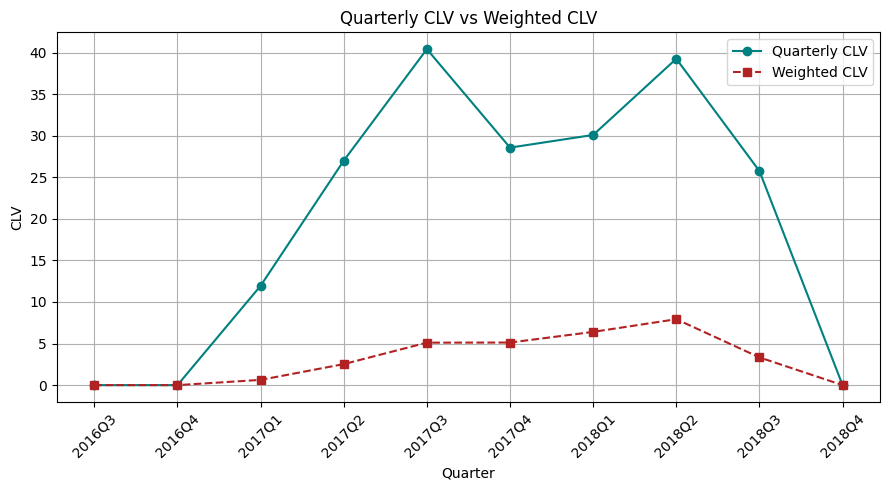

In [21]:
# Plot the CLV
plt.figure(figsize = (9, 5))
# Plot regular CLV
plt.plot(clv_by_quarter_df["quarter"].astype(str), clv_by_quarter_df["clv"],
         marker = "o", linestyle = "-", color = "teal", label = "Quarterly CLV")

# Plot weighted CLV
plt.plot(clv_by_quarter_df["quarter"].astype(str), clv_by_quarter_df["weighted_clv"],
         marker = "s", linestyle = "--", color = "firebrick", label = "Weighted CLV")

plt.title("Quarterly CLV vs Weighted CLV")
plt.xlabel("Quarter")
plt.ylabel("CLV")
plt.grid(True)
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

**Remarks:**  
***If the CLV is increasing over time, it indicates that customers are becoming more valuable.***

* If the two lines are close to each other, it means that customer activity is relatively evenly distributed across quarters, and the raw CLV is a good representation of overall performance.

* If the two lines diverge significantly, it indicates that customer activity is unevenly distributed, and the weighted CLV provides a more accurate picture of overall performance.

* For example, if the quarterly CLV is high but the weighted CLV is low, it means that the high CLV is driven by a small number of active customers.

**Actionable Insights:**   
--> Analyze what drove high CLV and high customer activity in these quarters (e.g., marketing campaigns, seasonal trends).  
--> If quarterly CLV is high but weighted CLV is low, focus on increasing customer activity.

#### Churn Analysis

In [22]:
# Define churn as no purchase in the last X days
churn_threshold = 60

# Find the most recent purchase date in the dataset
max_purchase_date = df["order_purchase_timestamp"].max()

# Group by customer and find their last purchase date
last_purchase_date = df.groupby("customer_unique_id")["order_purchase_timestamp"].max().reset_index()

# Calculate whether a customer has churned
last_purchase_date["churned"] = (max_purchase_date -
                                 last_purchase_date["order_purchase_timestamp"]).dt.days > churn_threshold

# Identify churned customers
churned_customers = last_purchase_date[last_purchase_date["churned"] == True]
print("*--" * 12)
print(f"Number of Churned Customers: {len(churned_customers)}")
print("--" * 18)
print(f"Churned Customers Percentage: {round(len(churned_customers) / df['customer_unique_id'].nunique() * 100, 2)}%")
print("*--" * 12)

*--*--*--*--*--*--*--*--*--*--*--*--
Number of Churned Customers: 94422
------------------------------------
Churned Customers Percentage: 98.26%
*--*--*--*--*--*--*--*--*--*--*--*--
